<a href="https://colab.research.google.com/github/gioguarnieri/Materias_Doutorado_INPE/blob/main/Estat%C3%ADstica_Computacional/CAP417HandsOn3Giovanni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP 417 - PARTE C - HANDS-ON 03

## Nome: Giovanni Guarnieri Soares


In [89]:
!pip install colorednoise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## SpecplusV01.py

In [90]:
# ------------------------------------------------------------------------
# SpecplusV01.py
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats, optimize
import numpy as np
import math
import colorednoise as cn

__author__ = 'Paulo Giovani'
__copyright__ = 'Copyright 2017, 3DBMO Project INPE'
__credits__ = ['Paulo Giovani', 'Reinaldo Roberto Rosa', 'Murilo da Silva Dantas']
__license__ = 'GPL'
__version__ = '0.1B'
__maintainer__ = 'Paulo Giovani'
__email__ = 'pg_faria@yahoo.com.br'

#---------------------------------------------------------------------
# Calcula o PSD da série temporal
#---------------------------------------------------------------------
def psd(data):
	"""Calcula o PSD de uma série temporal."""
	
	# Define um intervalo para realizar o ajuste da reta
	INICIO = 10
	FIM = 800
	
	# O vetor com o tempo é o tamanho do número de pontos
	N = len(data)
	tempo = np.arange(len(data))

	# Define a frequência de amostragem
	dt = (tempo[-1] - tempo[0] / (N - 1))
	fs = 1 / dt

	# Calcula o PSD utilizando o MLAB
	power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)

	# Calcula a porcentagem de pontos utilizados na reta de ajuste
	totalFrequencias = len(freqs)
	totalPSD = FIM - INICIO
	porcentagemPSD = int(100 * totalPSD / totalFrequencias)

	# Seleciona os dados dentro do intervalo de seleção
	xdata = freqs[INICIO:FIM]
	ydata = power[INICIO:FIM]

	# Simula o erro
	yerr = 0.2 * ydata

	# Define uma função para calcular a Lei de Potência
	powerlaw = lambda x, amp, index: amp * (x**index)

	# Converte os dados para o formato LOG
	logx = np.log10(xdata)
	logy = np.log10(ydata)

	# Define a função para realizar o ajuste
	fitfunc = lambda p, x: p[0] + p[1] * x
	errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
	logyerr = yerr / ydata

	# Calcula a reta de ajuste
	pinit = [1.0, -1.0]
	out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
	pfinal = out[0]
	covar = out[1]
	index = pfinal[1]
	amp = 10.0 ** pfinal[0]
	indexErr = np.sqrt(covar[0][0])
	ampErr = np.sqrt(covar[1][1]) * amp
	
	# Retorna os valores obtidos
	return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM
	
#---------------------------------------------------------------------
# Calcula o DFA 1D da série temporal
#---------------------------------------------------------------------
def dfa1d(timeSeries, grau):
	"""Calcula o DFA 1D (adaptado de Physionet), onde a escala cresce
	de acordo com a variável 'Boxratio'. Retorna o array 'vetoutput', 
	onde a primeira coluna é o log da escala S e a segunda coluna é o
	log da função de flutuação."""

	# 1. A série temporal {Xk} com k = 1, ..., N é integrada na chamada função perfil Y(k)
	x = np.mean(timeSeries)
	timeSeries = timeSeries - x
	yk = np.cumsum(timeSeries)
	tam = len(timeSeries)

	# 2. A série (ou perfil) Y(k) é dividida em N intervalos não sobrepostos de tamanho S
	sf = np.ceil(tam / 4).astype(np.int)
	boxratio = np.power(2.0, 1.0 / 8.0)
	vetoutput = np.zeros(shape = (1,2))

	s = 4
	while s <= sf:        
		serie = yk        
		if np.mod(tam, s) != 0:
			l = s * int(np.trunc(tam/s))
			serie = yk[0:l]			
		t = np.arange(s, len(serie), s)
		v = np.array(np.array_split(serie, t))
		l = len(v)
		x = np.arange(1, s + 1)
		
		# 3. Calcula-se a variância para cada segmento v = 1,…, n_s:
		p = np.polynomial.polynomial.polyfit(x, v.T, grau)
		yfit = np.polynomial.polynomial.polyval(x, p)
		vetvar = np.var(v - yfit)
		
		# 4. Calcula-se a função de flutuação DFA como a média das variâncias de cada intervalo
		fs = np.sqrt(np.mean(vetvar))
		vetoutput = np.vstack((vetoutput,[s, fs]))
		
		# A escala S cresce numa série geométrica
		s = np.ceil(s * boxratio).astype(np.int)

	# Array com o log da escala S e o log da função de flutuação   
	vetoutput = np.log10(vetoutput[1::1,:])

	# Separa as colunas do vetor 'vetoutput'
	x = vetoutput[:,0]
	y = vetoutput[:,1]

	# Regressão linear
	slope, intercept, _, _, _ = stats.linregress(x, y)

	# Calcula a reta de inclinação
	predict_y = intercept + slope * x

	# Calcula o erro
	pred_error = y - predict_y

	# Retorna o valor do ALFA, o vetor 'vetoutput', os vetores X e Y,
	# o vetor com os valores da reta de inclinação e o vetor de erros
	return slope, vetoutput, x, y, predict_y, pred_error

In [91]:
def graficos(data):
	"""Função com o código princiapl do programa."""
	
	print("\nData Analysis for 3DBMO simulations...\n")
	
	# Desabilita as mensagens de erro do Numpy (warnings)
	old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
		
	# Exibe os primeiro N valores do arquivo
	N = 10
	print("Original time series data (%d points): \n" %(len(data)))
	print("First %d points: %s\n" %(N, data[0:10]))
	print()
	
	#-----------------------------------------------------------------
    # Parâmetros gerais de plotagem
    #-----------------------------------------------------------------
	
	# Define os subplots
	fig = plt.figure()
	fig.subplots_adjust(hspace = .3, wspace = .2)
	
	# Tamanho das fontes
	tamanhoFonteEixoX = 16
	tamanhoFonteEixoY = 16
	tamanhoFonteTitulo = 16
	tamanhoFontePrincipal = 25
	
	# Título principal
	tituloPrincipal = 'Spectral Time Series Analysis' 	
	
	#-----------------------------------------------------------------
    # Plotagem da série original
    #-----------------------------------------------------------------
	
	# Define as cores da plotagem
	corSerieOriginal = 'r'
	
	# Título dos eixos da série original
	textoEixoX = 'Tempo'
	textoEixoY = 'Amplitude'
	textoTituloOriginal = 'Original Time Series Data'
	
	print("1. Plotting time series data...")
	
	# Plotagem da série de dados    
	#O = fig.add_subplot(1, 3, 1)    
	O = fig.add_subplot(2, 1, 1)
	O.plot(data, '-', color = corSerieOriginal)
	O.set_title(textoTituloOriginal, fontsize = tamanhoFonteTitulo)
	O.set_xlabel(textoEixoX, fontsize = tamanhoFonteEixoX)
	O.set_ylabel(textoEixoY, fontsize = tamanhoFonteEixoY)
	O.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
	O.grid()
	
	#-----------------------------------------------------------------
    # Cálculo e plotagem do PSD
    #-----------------------------------------------------------------
	
	# Calcula o PSD
	freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)

	# O valor do beta equivale ao index
	b = index

	# Define as cores da plotagem
	corPSD1 = 'k'
	corPSD2 = 'navy'

	# Título dos eixos do PSD
	textoPSDX = 'Frequência (Hz)'
	textoPSDY = 'Potência'
	textoTituloPSD = r'Power Spectrum Density $\beta$ = '
	
	print("2. Plotting Power Spectrum Density...")

	# Plotagem do PSD    
	PSD = fig.add_subplot(2, 2, 3)    
	PSD.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
	PSD.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
	PSD.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
	PSD.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
	PSD.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
	PSD.set_xlabel(textoPSDX, fontsize = tamanhoFonteEixoX)
	PSD.set_ylabel(textoPSDY, fontsize = tamanhoFonteEixoY)
	PSD.set_title(textoTituloPSD + '%.4f' %(b), loc = 'center', fontsize = tamanhoFonteTitulo)
	PSD.set_yscale('log')
	PSD.set_xscale('log')
	PSD.grid() 
	
	#-----------------------------------------------------------------
	# Cálculo e plotagem do DFA
    #-----------------------------------------------------------------
	        
	# Calcula o DFA 1D
	alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)

	# Verifica se o DFA possui um valor válido
	# Em caso afirmativo, faz a plotagem
	if not math.isnan(alfa):
		
		# Define as cores da plotagem
		corDFA = 'darkmagenta'

		# Título dos eixos do DFA
		textoDFAX = '$log_{10}$ (s)'
		textoDFAY = '$log_{10}$ F(s)'
		textoTituloDFA = r'Detrended Fluctuation Analysis $\alpha$ = '
		
		print("3. Plotting Detrended Fluctuation Analysis...")
		
		# Plotagem do DFA 
		DFA = fig.add_subplot(2, 2, 4)    
		DFA.plot(x, y, 's', 
				 color = corDFA, 
				 markersize = 4,
				 markeredgecolor = 'r',
				 markerfacecolor = 'None',
				 alpha = 0.8)				 
		DFA.plot(x, reta, '-', color = corDFA, linewidth = 1.5)
		DFA.set_title(textoTituloDFA + '%.4f' %(alfa), loc = 'center', fontsize = tamanhoFonteTitulo)
		DFA.set_xlabel(textoDFAX, fontsize = tamanhoFonteEixoX)
		DFA.set_ylabel(textoDFAY, fontsize = tamanhoFonteEixoY)
		DFA.grid()

	else:  
		DFA = fig.add_subplot(2, 2, 4)
		DFA.set_title(textoTituloDFA + 'N.A.', loc = 'center', fontsize = tamanhoFonteTitulo)
		DFA.grid()

	#-----------------------------------------------------------------
	# Exibe e salva a figura
	#-----------------------------------------------------------------
	plt.suptitle(tituloPrincipal, fontsize = tamanhoFontePrincipal)
	nomeImagem = '3DBMO_PSD_DFA_2.png'
	fig.set_size_inches(15, 9)
	plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)	
	plt.show()
	return alfa,b

## Task 1 - Calcular DFA e PSD para colored noise e janelamento

In [92]:
gamma1 = []


Data Analysis for 3DBMO simulations...

Original time series data (4096 points): 

First 10 points: [ 0.30669297 -0.39911585  0.46277949 -0.46578327  0.0414789   0.50205532
 -0.88387529  1.64429823 -1.27005408 -1.62463168]


1. Plotting time series data...
2. Plotting Power Spectrum Density...
3. Plotting Detrended Fluctuation Analysis...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

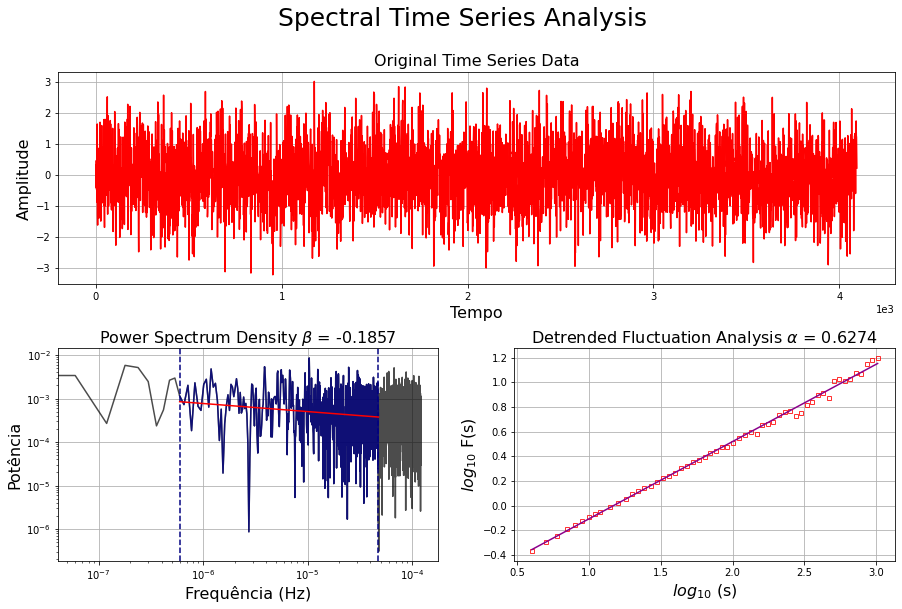

In [93]:
serie1 = cn.powerlaw_psd_gaussian(0.2,4096,random_state=8666)
alfa, b = graficos(serie1)
gamma1.append(2/7*(alfa-b))


Data Analysis for 3DBMO simulations...

Original time series data (4096 points): 

First 10 points: [-0.63934485 -1.00143347 -0.25312311  0.27892576 -0.06393418 -0.53896342
  0.59958265  0.86303417  1.02099343  1.33687649]


1. Plotting time series data...
2. Plotting Power Spectrum Density...
3. Plotting Detrended Fluctuation Analysis...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

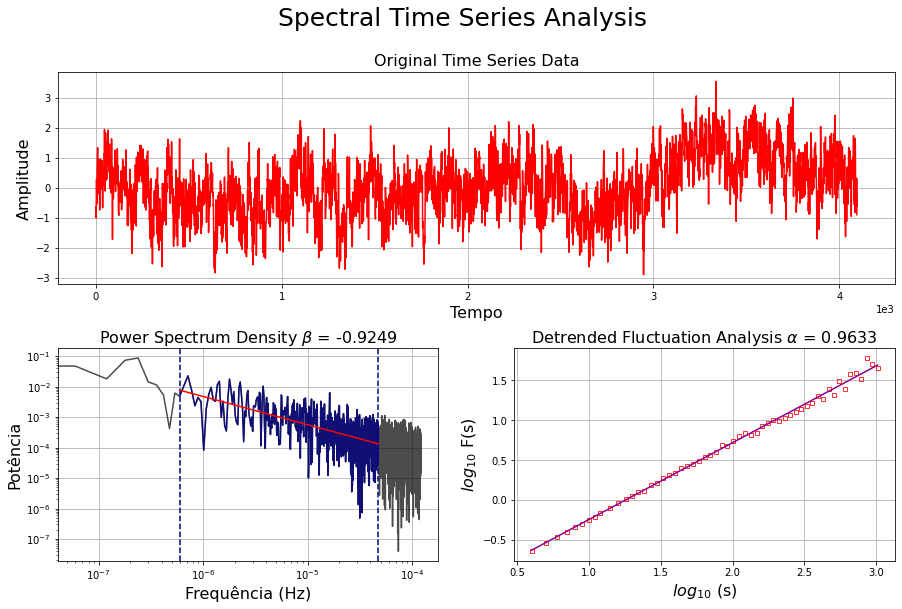

In [94]:
serie2 = cn.powerlaw_psd_gaussian(1,4096,random_state=1)
alfa, b = graficos(serie2)
gamma1.append(2/7*(alfa-b))


Data Analysis for 3DBMO simulations...

Original time series data (4096 points): 

First 10 points: [0.57422003 0.56404251 0.62769143 0.6823443  0.67363743 0.66463266
 0.75949083 0.80637712 0.8334335  0.85207231]


1. Plotting time series data...
2. Plotting Power Spectrum Density...
3. Plotting Detrended Fluctuation Analysis...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

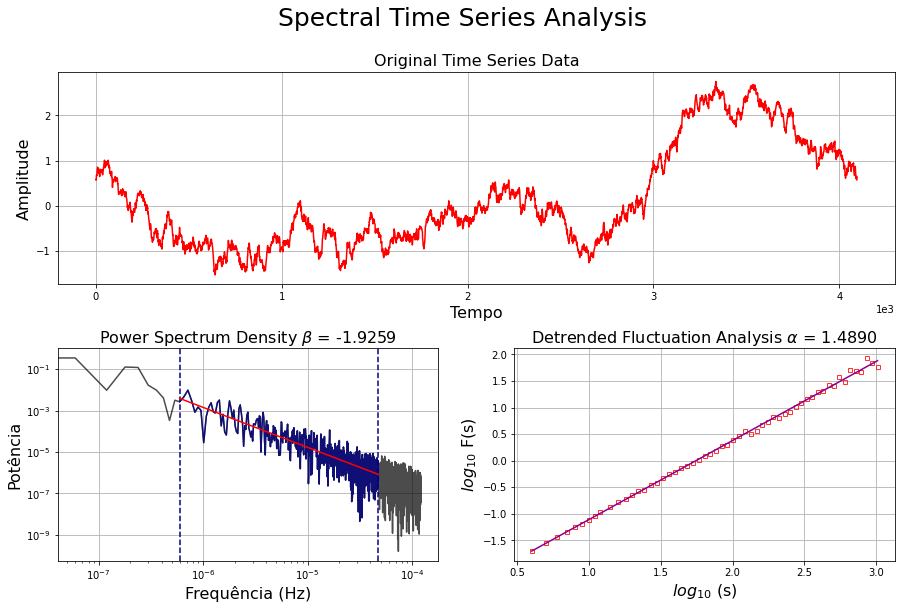

In [95]:
serie3 = cn.powerlaw_psd_gaussian(2,4096,random_state=1)
alfa, b = graficos(serie3)
gamma1.append(2/7*(alfa-b))

## Task 2 - Calcular MFDFA

### MFDFA modulos

In [96]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module A
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m1.py
# This code implements a modification of the first-order unifractal analysis algorithm originally described in [1].
# It covers both the detrended fluctuation analysis (DFA) and the Hurst (a.k.a. R/S) analysis methods. For more details
# on the DFA and Hurst analysis methods, please refer to [2, 3].
#
# At the input, 'dx' is a time series of increments of the physical observable 'x(t)', of the length equal to an
# integer power of two greater than two (i.e. 4, 8, 16, 32, etc.), 'normType_p' is any real greater than or
# equal to one specifying the p-norm, 'isDFA' is a boolean value prescribing to use either the DFA-based algorithm or
# the standard Hurst (a.k.a. R/S) analysis, 'normType_q' is any real greater than or equal to one specifying the q-norm.
#
# At the output, 'timeMeasure' is the time measure of the data's support at different scales, 'meanDataMeasure' is
# the data measure at different scales, while 'scales' is the scales at which the data measure is computed.
#
# The conventional way of using the output values is to plot the data measure vs the scales; the time measure,
# being the inverse quantity to the scales, is computed for an alternative representation and may be ignored.
#
# The requirement to have a power-of-two data length is aimed at avoiding inaccuracies when computing the data measure
# on different time scales.
#
# REFERENCES:
# [1] D.M. Filatov, J. Stat. Phys., 165 (2016) 681-692. DOI: 10.1007/s10955-016-1641-6.
# [2] J.W. Kantelhardt, Fractal and Multifractal Time Series, available at http://arxiv.org/abs/0804.0747, 2008.
# [3] J. Feder, Fractals, Plenum Press, New York, 1988.
#
# The end user is granted perpetual permission to reproduce, adapt, and/or distribute this code, provided that
# an appropriate link is given to the original repository it was downloaded from.

#input: read your time series as a 1d vector, with size 2ˆn, named:  dx


def getHurstByUpscaling(dx, normType_p = np.inf, isDFA = 1, normType_q = 1.0):
    ## Some initialiation
    dx_len = len(dx)

    # We have to reserve the most major scale for shifts, so we divide the data
    # length by two. (As a result, the time measure starts from 2.0, not from
    # 1.0, see below.)
    dx_len = np.int(dx_len / 2)

    dx_shift = np.int(dx_len / 2)

    nScales = np.int(np.round(np.log2(dx_len)))    # Number of scales involved. P.S. We use 'round()' to prevent possible malcomputing of the logarithms
    j = 2 ** (np.arange(1, nScales + 1) - 1) - 1

    meanDataMeasure = np.zeros(nScales)

    ## Computing the data measure
    for ji in range(1, nScales + 1):
        # At the scale 'j(ji)' we deal with '2 * (j(ji) + 1)' elements of the data 'dx'
        dx_k_len = 2 * (j[ji - 1] + 1)
        n = np.int(dx_len / dx_k_len)

        dx_leftShift = np.int(dx_k_len / 2)
        dx_rightShift = np.int(dx_k_len / 2)

        for k in range(1, n + 1):
            # We get a portion of the data of the length '2 * (j(ji) + 1)' plus the data from the left and right boundaries
            dx_k_withShifts = dx[(k - 1) * dx_k_len + 1 + dx_shift - dx_leftShift - 1 : k * dx_k_len + dx_shift + dx_rightShift]

            # Then we perform free upscaling and, using the above-selected data (provided at the scale j = 0),
            # compute the velocities at the scale 'j(ji)'
            j_dx = np.convolve(dx_k_withShifts, np.ones(dx_rightShift), 'valid')

            # Then we compute the accelerations at the scale 'j(ji) + 1'
            r = (j_dx[1 + dx_rightShift - 1 : ] - j_dx[1 - 1 : -dx_rightShift]) / 2.0

            # Finally, we compute the range ...
            if (normType_p == 0):
                R = np.max(r[2 - 1 : ]) - np.min(r[2 - 1 : ])
            elif (np.isinf(normType_p)):
                R = np.max(np.abs(r[2 - 1 : ]))
            else:
                R = (np.sum(r[2 - 1 : ] ** normType_p) / len(r[2 - 1 : ])) ** (1.0 / normType_p)
            # ... and the normalisation factor ("standard deviation")
            S = np.sqrt(np.sum(np.abs(np.diff(r)) ** 2.0) / (len(r) - 1))
            if (isDFA == 1):
                S = 1.0

            meanDataMeasure[ji - 1] += (R / S) ** normType_q
        meanDataMeasure[ji - 1] = (meanDataMeasure[ji - 1] / n) ** (1.0 / normType_q)

    # We pass from the scales ('j') to the time measure; the time measure at the scale j(nScales) (the most major one)
    # is assumed to be 2.0, while it is growing when the scale is tending to j(1) (the most minor one).
    # (The scale j(nScales)'s time measure is NOT equal to 1.0, because we reserved the highest scale for shifts
    # in the very beginning of the function.)
    timeMeasure = 2.0 * dx_len / (2 * (j + 1))

    scales = j + 1

    return [timeMeasure, meanDataMeasure, scales]

In [97]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module B
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m2.py
# This code implements a modification of the first-order multifractal analysis algorithm. It is based on the
# corresponding unifractal analysis technique described in [1]. It computes the Lipschitz-Holder multifractal
# singularity spectrum, as well as the minimum and maximum generalised Hurst exponents [2, 3].
#
# At the input, 'dx' is a time series of increments of the physical observable 'x(t)', of the length equal to an
# integer power of two greater than two (i.e. 4, 8, 16, 32, etc.), 'normType' is any real greater than or
# equal to one specifying the p-norm, 'isDFA' is a boolean value prescribing to use either the DFA-based algorithm or
# the standard Hurst (a.k.a. R/S) analysis, 'isNormalised' is a boolean value prescribing either to normalise the
# intermediate range-to-deviation (R/S) expression or to proceed computing without normalisation.
#
# At the output, 'timeMeasure' is the time measure of the data's support at different scales, 'dataMeasure' is
# the data measure at different scales computed for each value of the variable q-norm, 'scales' is the scales at which
# the data measure is computed, 'stats' is the structure containing MF-DFA statistics, while 'q' is the values of the
# q-norm used.
#
# Similarly to unifractal analysis (see getHurstByUpscaling()), the time measure is computed merely for an alternative
# representation of the dependence 'dataMeasure(q, scales) ~ scales ^ -tau(q)'.
#
# REFERENCES:
# [1] D.M. Filatov, J. Stat. Phys., 165 (2016) 681-692. DOI: 10.1007/s10955-016-1641-6.
# [2] J.W. Kantelhardt, Fractal and Multifractal Time Series, available at http://arxiv.org/abs/0804.0747, 2008.
# [3] J. Feder, Fractals, Plenum Press, New York, 1988.
#
# The end user is granted perpetual permission to reproduce, adapt, and/or distribute this code, provided that
# an appropriate link is given to the original repository it was downloaded from.


def getMSSByUpscaling(dx, normType = np.inf, isDFA = 1, isNormalised = 1):
    ## Some initialiation
    aux_eps = np.finfo(float).eps

    # We prepare an array of values of the variable q-norm
    aux = [-16.0, -8.0, -4.0, -2.0, -1.0, -0.5, -0.0001, 0.0, 0.0001, 0.5, 0.9999, 1.0, 1.0001, 2.0, 4.0, 8.0, 16.0, 32.0]
    nq = len(aux)

    q = np.zeros((nq, 1))
    q[:, 1 - 1] = aux

    dx_len = len(dx)

    # We have to reserve the most major scale for shifts, so we divide the data
    # length by two. (As a result, the time measure starts from 2.0, not from
    # 1.0, see below.)
    dx_len = np.int(dx_len / 2)

    dx_shift = np.int(dx_len / 2)

    nScales = np.int(np.round(np.log2(dx_len)))    # Number of scales involved. P.S. We use 'round()' to prevent possible malcomputing of the logarithms
    j = 2 ** (np.arange(1, nScales + 1) - 1) - 1

    dataMeasure = np.zeros((nq, nScales))

    ## Computing the data measures in different q-norms
    for ji in range(1, nScales + 1):
        # At the scale 'j(ji)' we deal with '2 * (j(ji) + 1)' elements of the data 'dx'
        dx_k_len = 2 * (j[ji - 1] + 1)
        n = np.int(dx_len / dx_k_len)

        dx_leftShift = np.int(dx_k_len / 2)
        dx_rightShift = np.int(dx_k_len / 2)

        R = np.zeros(n)
        S = np.ones(n)
        for k in range(1, n + 1):
            # We get a portion of the data of the length '2 * (j(ji) + 1)' plus the data from the left and right boundaries
            dx_k_withShifts = dx[(k - 1) * dx_k_len + 1 + dx_shift - dx_leftShift - 1 : k * dx_k_len + dx_shift + dx_rightShift]

            # Then we perform free upscaling and, using the above-selected data (provided at the scale j = 0),
            # compute the velocities at the scale 'j(ji)'
            j_dx = np.convolve(dx_k_withShifts, np.ones(dx_rightShift), 'valid')

            # Then we compute the accelerations at the scale 'j(ji) + 1'
            r = (j_dx[1 + dx_rightShift - 1 : ] - j_dx[1 - 1 : -dx_rightShift]) / 2.0

            # Finally we compute the range ...
            if (normType == 0):
                R[k - 1] = np.max(r[2 - 1 : ]) - np.min(r[2 - 1 : ])
            elif (np.isinf(normType)):
                R[k - 1] = np.max(np.abs(r[2 - 1 : ]))
            else:
                R[k - 1] = (np.sum(r[2 - 1 : ] ** normType) / len(r[2 - 1 : ])) ** (1.0 / normType)
            # ... and the normalisation factor ("standard deviation")
            if (isDFA == 0):
                S[k - 1] = np.sqrt(np.sum(np.abs(np.diff(r)) ** 2.0) / (len(r) - 1))

        if (isNormalised == 1):      # Then we either normalise the R / S values, treating them as probabilities ...
            p = np.divide(R, S) / np.sum(np.divide(R, S))
        else:                        # ... or leave them unnormalised ...
            p = np.divide(R, S)
        # ... and compute the measures in the q-norms
        for k in range(1, n + 1):
            # This 'if' is needed to prevent measure blow-ups with negative values of 'q' when the probability is close to zero
            if (p[k - 1] < 1000.0 * aux_eps):
                continue

            dataMeasure[:, ji - 1] = dataMeasure[:, ji - 1] + np.power(p[k - 1], q[:, 1 - 1])

    # We pass from the scales ('j') to the time measure; the time measure at the scale j(nScales) (the most major one)
    # is assumed to be 2.0, while it is growing when the scale is tending to j(1) (the most minor one).
    # (The scale j(nScales)'s time measure is NOT equal to 1.0, because we reserved the highest scale for shifts
    # in the very beginning of the function.)
    timeMeasure = 2.0 * dx_len / (2 * (j + 1))

    scales = j + 1

    ## Determining the exponents 'tau' from 'dataMeasure(q, timeMeasure) ~ timeMeasure ^ tau(q)'
    tau = np.zeros((nq, 1))
    log10tm = np.log10(timeMeasure)
    log10dm = np.log10(dataMeasure)
    log10tm_mean = np.mean(log10tm)

    # For each value of the q-norm we compute the mean 'tau' over all the scales
    for qi in range(1, nq + 1):
        tau[qi - 1, 1 - 1] = np.sum(np.multiply(log10tm, (log10dm[qi - 1, :] - np.mean(log10dm[qi - 1, :])))) / np.sum(np.multiply(log10tm, (log10tm - log10tm_mean)))

    ## Finally, we only have to pass from 'tau(q)' to its conjugate function 'f(alpha)'
    # In doing so, first we find the Lipschitz-Holder exponents 'alpha' (represented by the variable 'LH') ...
    aux_top = (tau[2 - 1] - tau[1 - 1]) / (q[2 - 1] - q[1 - 1])
    aux_middle = np.divide(tau[3 - 1 : , 1 - 1] - tau[1 - 1 : -1 - 1, 1 - 1], q[3 - 1 : , 1 - 1] - q[1 - 1 : -1 - 1, 1 - 1])
    aux_bottom = (tau[-1] - tau[-1 - 1]) / (q[-1] - q[-1 - 1])
    LH = np.zeros((nq, 1))
    LH[:, 1 - 1] = -np.concatenate((aux_top, aux_middle, aux_bottom))
    # ... and then compute the conjugate function 'f(alpha)' itself
    f = np.multiply(LH, q) + tau

    ## The last preparations
    # We determine the minimum and maximum values of 'alpha' ...
    LH_min = LH[-1, 1 - 1]
    LH_max = LH[1 - 1, 1 - 1]
    # ... and find the minimum and maximum values of another multifractal characteristic, the so-called
    # generalised Hurst (or DFA) exponent 'h'. (These parameters are computed according to [2, p. 27].)
    h_min = -(1.0 + tau[-1, 1 - 1]) / q[-1, 1 - 1]
    h_max = -(1.0 + tau[1 - 1, 1 - 1]) / q[1 - 1, 1 - 1]

    stats = {'tau':       tau,
             'LH':        LH,
             'f':         f,
             'LH_min':    LH_min,
             'LH_max':    LH_max,
             'h_min':     h_min,
             'h_max':     h_max}

    return [timeMeasure, dataMeasure, scales, stats, q]

In [98]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module D
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m3.py
# This function determines the optimal linear approximations of the data measure using two segments and returns
# the index of the corresponding boundary scale (a.k.a. crossover), the boundary scale itself, as well as the
# unifractal characteristics at the major and minor scales. For examples of using crossovers, see [1, 2].
#
# At the input, 'timeMeasure' is a time measure at different scales, while 'dataMeasure' is a data measure at the same
# scales.
#
# At the output, 'bScale' is the boundary scale, or crossover, separating the major and minor scales, 'bDM' is the
# data measure at the boundary scale, 'bsIndex' is the crossover's index with respect to the time measure, 'HMajor' is
# the unifractal dimension at the major scales, 'HMinor' is the unifractal dimension at the minor scales.
#
# REFERENCES:
# [1] D.M. Filatov, J. Stat. Phys., 165 (2016) 681-692. DOI: 10.1007/s10955-016-1641-6.
# [2] C.-K. Peng, S. Havlin, H.E. Stanley and A.L. Goldberger, Chaos, 5 (1995) 82–87. DOI: 10.1063/1.166141.
#
# The end user is granted perpetual permission to reproduce, adapt, and/or distribute this code, provided that
# an appropriate link is given to the original repository it was downloaded from.

def getScalingExponents(timeMeasure, dataMeasure):
    ## Initialisation
    nScales = len(timeMeasure)

    log10tm = np.log10(timeMeasure)
    log10dm = np.log10(dataMeasure)

    res = 1.0e+07
    bsIndex = nScales

    ## Computing
    # We find linear approximations for major and minor subsets of the data measure and determine the index of the
    # boundary scale at which the approximations are optimal in the sense of best fitting to the data measure
    for i in range(3, nScales - 2 + 1):
        # Major 'i' scales are approximated by the function 'k * x + b' ...
        curr_log10tm = log10tm[nScales - i + 1 - 1 : nScales]
        curr_log10dm = log10dm[nScales - i + 1 - 1 : nScales]
        detA = i * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
        detK = i * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
        detB = np.sum(curr_log10dm) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) * np.sum(np.multiply(curr_log10tm, curr_log10dm))
        k = detK / detA
        b = detB / detA
        # ... and the maximum residual is computed
        resMajor = max(np.abs(k * curr_log10tm + b - curr_log10dm))

        # Minor 'nScales - i + 1' scales are approximated by the function 'k * x + b' ...
        curr_log10tm = log10tm[1 - 1 : nScales - i + 1]
        curr_log10dm = log10dm[1 - 1 : nScales - i + 1]
        detA = (nScales - i + 1) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
        detK = (nScales - i + 1) * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
        detB = np.sum(curr_log10dm) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) * np.sum(np.multiply(curr_log10tm, curr_log10dm))
        k = detK / detA
        b = detB / detA
        # ... and the maximum residual is computed
        resMinor = max(np.abs(k * curr_log10tm + b - curr_log10dm))

        if (resMajor ** 2.0 + resMinor ** 2.0 < res):
            res = resMajor ** 2.0 + resMinor ** 2.0
            bsIndex = i

    # Now we determine the boundary scale and the boundary scale's data measure, ...
    bScale = 2.0 * timeMeasure[1 - 1] / timeMeasure[nScales - bsIndex + 1 - 1] / 2.0
    bDM = dataMeasure[nScales - bsIndex + 1 - 1]
    # ... as well as compute the unifractal dimensions using the boundary scale's index:
    # at the major 'bsIndex' scales ...
    curr_log10tm = log10tm[nScales - bsIndex + 1 - 1 : nScales]
    curr_log10dm = log10dm[nScales - bsIndex + 1 - 1 : nScales]
    detA = bsIndex * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
    detK = bsIndex * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
    DMajor = detK / detA
    HMajor = -DMajor
    # ... and at the minor 'nScales - bsIndex + 1' scales
    curr_log10tm = log10tm[1 - 1 : nScales - bsIndex + 1]
    curr_log10dm = log10dm[1 - 1 : nScales - bsIndex + 1]
    detA = (nScales - bsIndex + 1) * np.sum(curr_log10tm ** 2.0) - np.sum(curr_log10tm) ** 2.0
    detK = (nScales - bsIndex + 1) * np.sum(np.multiply(curr_log10tm, curr_log10dm)) - np.sum(curr_log10tm) * np.sum(curr_log10dm)
    DMinor = detK / detA
    HMinor = -DMinor

    return [bScale, bDM, bsIndex, HMajor, HMinor]

### Rodando MFDFA, beta = 0.2

In [99]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module D
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m4.py
#This module is the entry point for testing the modified first-order uni- and multifractal DFA methods.
#The initial dataset is a time series of size 2ˆn (tseries.txt) 
%%capture
from numpy import loadtxt

## Loading data
#dx = loadtxt('tseries.txt')
#size=8192
#dx = dx[1 - 1 : 8192]               # We take the first 8192 samples

dx = serie1

## Computing
# Modified first-order DFA
[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx)                    # Set of parameters No. 1
#[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx, 3.0, 0, 2.0)       # Set of parameters No. 2

[bScale, bDM, bsIndex, HMajor, HMinor] = getScalingExponents(timeMeasure, meanDataMeasure)

# Modified first-order MF-DFA
[_, dataMeasure, _, stats, q] = getMSSByUpscaling(dx, isNormalised = 1)
gamma2 = []

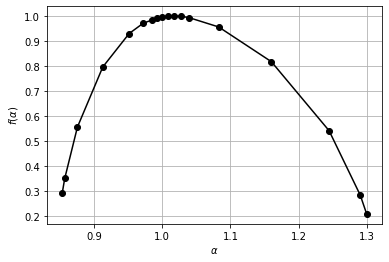

alpha_min = 0.85341, alpha_max = 1.29961, dalpha = 0.446204
h_min = 0.813004, h_max = 1.37511, dh = 0.562111



In [100]:
plt.plot(stats['LH'], stats['f'], 'ko-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$f(\alpha)$')
plt.grid('on', which = 'major')

plt.show()

#PRINTING SPECTRUM PARAMETERS
print('alpha_min = %g, alpha_max = %g, dalpha = %g' % (stats['LH_min'], stats['LH_max'], stats['LH_max'] - stats['LH_min']))
print('h_min = %g, h_max = %g, dh = %g\n' % (stats['h_min'], stats['h_max'], stats['h_max'] - stats['h_min']))

In [101]:
print(f"Gamma2 = {2/3*(stats['LH_max'] - stats['LH_min'])}")
gamma2.append(2/3*(stats['LH_max'] - stats['LH_min']))

Gamma2 = 0.29746935777678607


### Rodando MFDFA, beta = 1

In [102]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module D
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m4.py
#This module is the entry point for testing the modified first-order uni- and multifractal DFA methods.
#The initial dataset is a time series of size 2ˆn (tseries.txt) 
%%capture
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

## Loading data
#dx = loadtxt('tseries.txt')
#size=8192
#dx = dx[1 - 1 : 8192]               # We take the first 8192 samples

dx = serie2

## Computing
# Modified first-order DFA
[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx)                    # Set of parameters No. 1
#[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx, 3.0, 0, 2.0)       # Set of parameters No. 2

[bScale, bDM, bsIndex, HMajor, HMinor] = getScalingExponents(timeMeasure, meanDataMeasure)

# Modified first-order MF-DFA
[_, dataMeasure, _, stats, q] = getMSSByUpscaling(dx, isNormalised = 1)


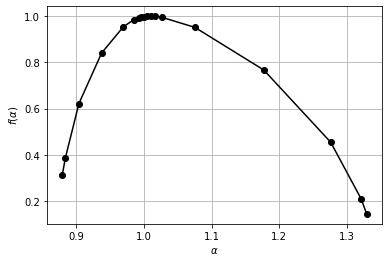

alpha_min = 0.879169, alpha_max = 1.32903, dalpha = 0.449865
h_min = 0.838124, h_max = 1.40053, dh = 0.562403



In [103]:
plt.plot(stats['LH'], stats['f'], 'ko-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$f(\alpha)$')
plt.grid('on', which = 'major')

plt.show()

#PRINTING SPECTRUM PARAMETERS
print('alpha_min = %g, alpha_max = %g, dalpha = %g' % (stats['LH_min'], stats['LH_max'], stats['LH_max'] - stats['LH_min']))
print('h_min = %g, h_max = %g, dh = %g\n' % (stats['h_min'], stats['h_max'], stats['h_max'] - stats['h_min']))

In [104]:
print(f"Gamma2 = {2/3*(stats['LH_max'] - stats['LH_min'])}")
gamma2.append(2/3*(stats['LH_max'] - stats['LH_min']))

Gamma2 = 0.29991020413511793


### Rodando MFDFA, beta = 2

In [105]:
#MFDFA-Analytics-by-SKDataScience
#multifractal DFA singularity spectra - module D
#Version 3.0 - Modified by R.R.Rosa - Dec 2018 - mfdfa_ss_m4.py
#This module is the entry point for testing the modified first-order uni- and multifractal DFA methods.
#The initial dataset is a time series of size 2ˆn (tseries.txt) 
%%capture
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

## Loading data
#dx = loadtxt('tseries.txt')
#size=8192
#dx = dx[1 - 1 : 8192]               # We take the first 8192 samples

dx = serie3

## Computing
# Modified first-order DFA
[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx)                    # Set of parameters No. 1
#[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx, 3.0, 0, 2.0)       # Set of parameters No. 2

[bScale, bDM, bsIndex, HMajor, HMinor] = getScalingExponents(timeMeasure, meanDataMeasure)

# Modified first-order MF-DFA
[_, dataMeasure, _, stats, q] = getMSSByUpscaling(dx, isNormalised = 1)


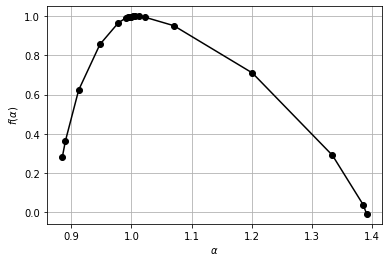

alpha_min = 0.885323, alpha_max = 1.39073, dalpha = 0.505409
h_min = 0.845326, h_max = 1.45262, dh = 0.607294



In [106]:
plt.plot(stats['LH'], stats['f'], 'ko-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$f(\alpha)$')
plt.grid('on', which = 'major')

plt.show()

#PRINTING SPECTRUM PARAMETERS
print('alpha_min = %g, alpha_max = %g, dalpha = %g' % (stats['LH_min'], stats['LH_max'], stats['LH_max'] - stats['LH_min']))
print('h_min = %g, h_max = %g, dh = %g\n' % (stats['h_min'], stats['h_max'], stats['h_max'] - stats['h_min']))

In [107]:
print(f"Gamma2 = {2/3*(stats['LH_max'] - stats['LH_min'])}")
gamma2.append(2/3*(stats['LH_max'] - stats['LH_min']))

Gamma2 = 0.33693944471060067


In [108]:
print(gamma1, gamma2)

[0.2323130794223559, 0.5395024508698606, 0.9756798526865715] [0.29746935777678607, 0.29991020413511793, 0.33693944471060067]


## Task 3: $\gamma_1 \times \gamma_2$ 

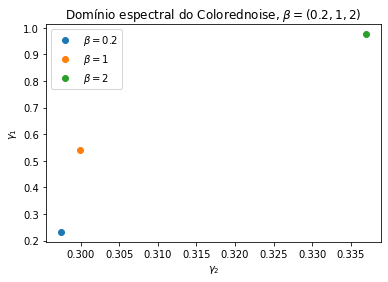

In [109]:
plt.figure()
plt.title(r"Domínio espectral do Colorednoise, $\beta=(0.2,1,2)$ ")
plt.plot(gamma2[0], gamma1[0], 'o', label=r"$\beta=0.2$")
plt.plot(gamma2[1], gamma1[1], 'o', label=r"$\beta=1$")
plt.plot(gamma2[2], gamma1[2], 'o', label=r"$\beta=2$")
plt.legend()
plt.xlabel(r'$\gamma_2$')
plt.ylabel(r'$\gamma_1$')
plt.show()